In [41]:
# Import necessary libraries
from __future__ import absolute_import, division, print_function

%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d

print("Version information")

print("python: {}".format(sys.version))
print("matplotlib: {}".format(matplotlib.__version__))
print("numpy: {}".format(np.__version__))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from naivebayes import EmotionClassifier, cross_validate_evaluate

import nltk
nltk.download('punkt')


Version information
python: 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
matplotlib: 3.7.4
numpy: 1.24.3


[nltk_data] Downloading package punkt to /Users/parag/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Load the dataset
df = pd.read_csv("../text.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


This Jupyter Notebook will guide you through the process of training all the models to classify emotions in text. It covers the preprocessing of text data, training the model, evaluating its performance using cross-validation, and finally visualizing the results using a confusion matrix.

<h2> Data Visualizations </h2>

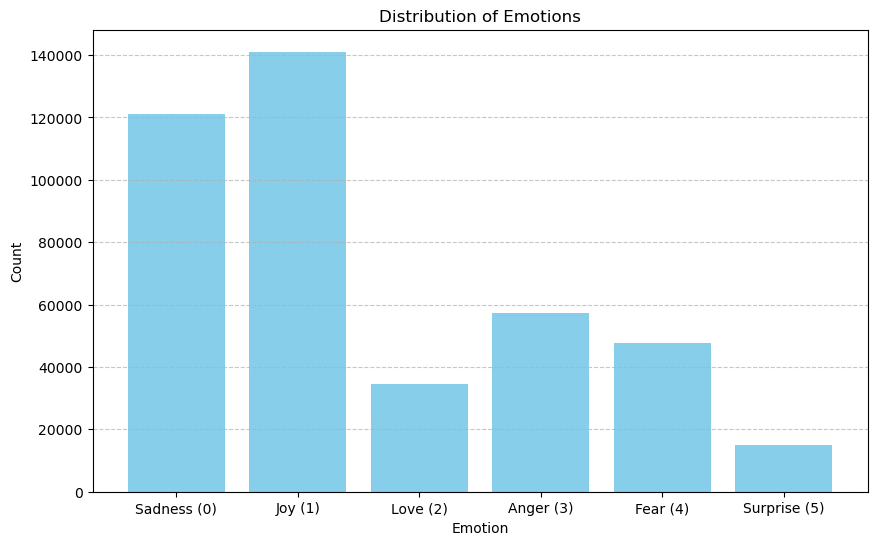

In [3]:

emotion_labels = {0: 'Sadness (0)', 1: 'Joy (1)', 2: 'Love (2)', 3: 'Anger (3)', 4: 'Fear (4)', 5: 'Surprise (5)'}
label_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(label_counts.index.map(emotion_labels), label_counts.values, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


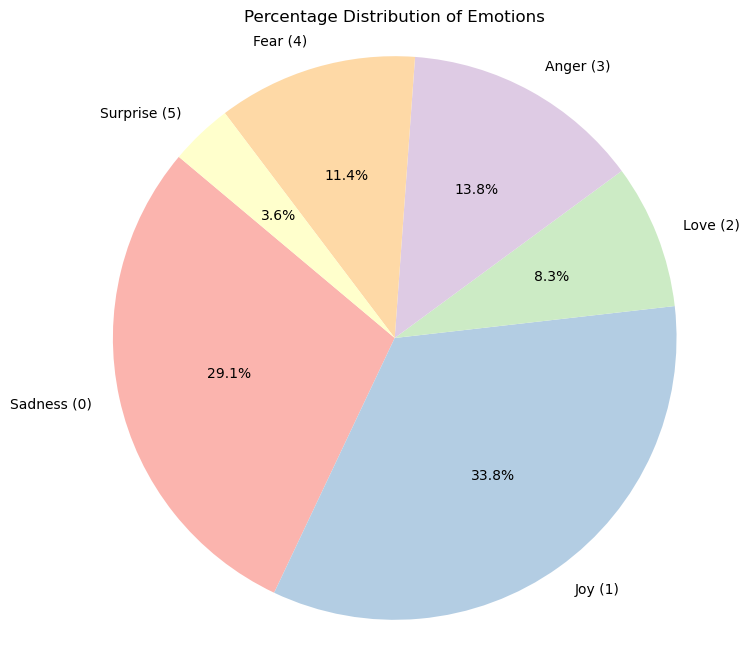

In [4]:
emotion_labels = {0: 'Sadness (0)', 1: 'Joy (1)', 2: 'Love (2)', 3: 'Anger (3)', 4: 'Fear (4)', 5: 'Surprise (5)'}
label_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(8, 8))
plt.pie(label_counts.values, labels=label_counts.index.map(emotion_labels), autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Percentage Distribution of Emotions')
plt.axis('equal')
plt.show()


# Emotion Classifier using Naive Bayes (Word2Vec)

### Reference: Emotions classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)

In [7]:
# Preprocess the text
df['processed_text'] = df['text'].apply(EmotionClassifier.preprocess_text)
df.head()

,Unnamed: 0,text,label,processed_text
0,0,i just feel really helpless and heavy hearted,4,i just feel really helpless and heavy hearted
1,1,ive enjoyed being able to slouch about relax a...,0,ive enjoyed being able to slouch about relax a...
2,2,i gave up my internship with the dmrg and am f...,4,i gave up my internship with the dmrg and am f...
3,3,i dont know i feel so lost,0,i dont know i feel so lost
4,4,i am a kindergarten teacher and i am thoroughl...,4,i am a kindergarten teacher and i am thoroughl...


In [8]:
# Convert data for cross-validation
X = df['processed_text'].to_numpy()
y = df['label'].to_numpy()

# Perform cross-validation and evaluate the model
acc, prec, f1, cm = cross_validate_evaluate(X, y)

print("Average Accuracy:", np.mean(acc))
print("Average Precision:", np.mean(prec))
print("Average F1-Score:", np.mean(f1))


Average Accuracy: 0.4064907407627499
Average Precision: 0.45094832020382825
Average F1-Score: 0.4169481168357446


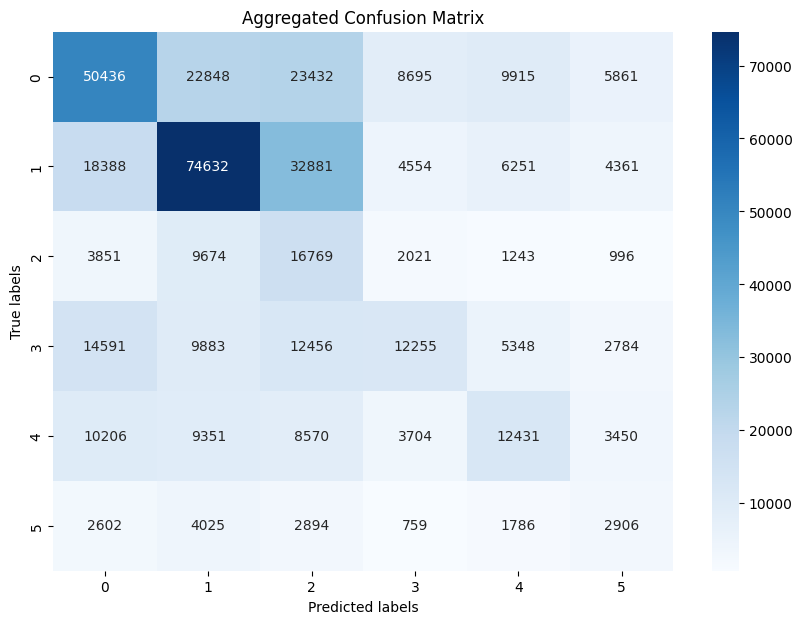

In [9]:
# Plot the aggregated confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix')
plt.show()

# Emotion Classifier using Multinomial Naive Bayes (with Bag-of-Words)

In [42]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/parag/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
class EmotionClassifier:
    def __init__(self):
        self.model_nb = MultinomialNB()
        self.vectorizer = CountVectorizer()

    @staticmethod
    def preprocess_text(text):
        # using text normalization for preprocessing
        text = text.lower()
        text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
        
        # tokenization for preprocessing
        tokens = word_tokenize(text)

        # negation handling for preprocessing
        negation_terms = {'not', 'no', 'never', 'none'}
        tokens = ['not_' + tokens[i+1] if tokens[i] in negation_terms and i+1 < len(tokens) else token 
                  for i, token in enumerate(tokens)]

        return ' '.join(tokens)

    def train(self, X_train, y_train):
        # convert the text data into a Bag-of-Words model that 
        # transforms text into a set of frequency counts of words 
        X_train_vect = self.vectorizer.fit_transform(X_train)
        # using multinomial nb 
        self.model_nb.fit(X_train_vect, y_train)

    def predict(self, X):
        # same as training using bag of words model 
        X_vect = self.vectorizer.transform(X)
        return self.model_nb.predict(X_vect)


In [44]:
# load and preprocess the data
df = pd.read_csv("../text.csv")
df['processed_text'] = df['text'].apply(EmotionClassifier.preprocess_text)

classifier = EmotionClassifier()

In [45]:
def cross_validate_evaluate(X, y):
    # using cross validation 
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    acc_scores, prec_scores, f1_scores = [], [], []
    aggregated_cm = np.zeros((6, 6))

    for train_index, test_index in kf.split(X):
        # split the data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        classifier.train(X_train, y_train)
        y_pred = classifier.predict(X_test)

        # Metrics
        acc_scores.append(accuracy_score(y_test, y_pred))
        prec_scores.append(precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))

        # Aggregate confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
        aggregated_cm += cm

    return acc_scores, prec_scores, f1_scores, aggregated_cm


In [46]:
# Need numpy array for crossvalid 
X = df['processed_text'].to_numpy()
y = df['label'].to_numpy()

acc, prec, f1, cm = cross_validate_evaluate(X, y)

print("Average Accuracy:", np.mean(acc))
print("Average Precision:", np.mean(prec))
print("Average F1-Score:", np.mean(f1))

Average Accuracy: 0.8581940440264126
Average Precision: 0.8576999118616433
Average F1-Score: 0.8514597655695431


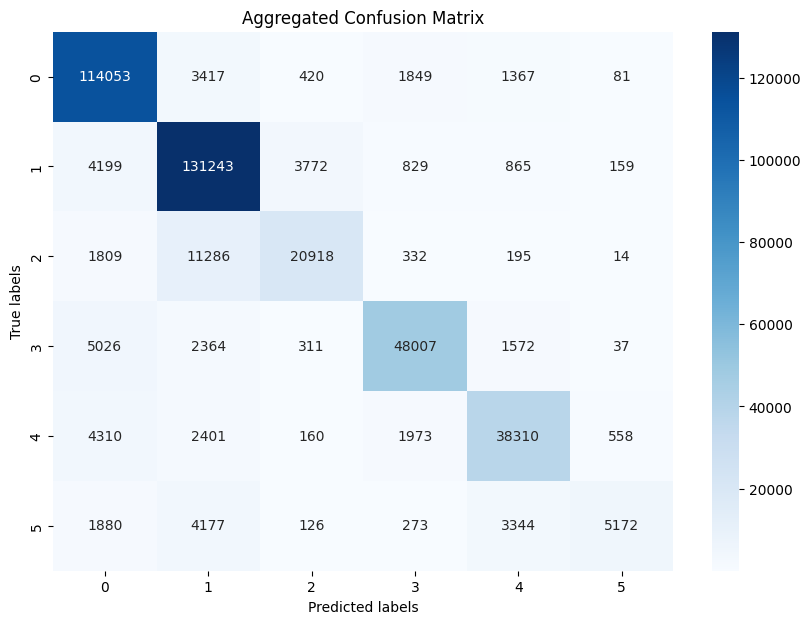

In [47]:
# plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix')
plt.show()

# Emotion Classifier using Linear SVM

In [3]:
import re
import pickle
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
class EmotionClassifier:
    def __init__(self):
        self.model = SVC(kernel='linear') 
        self.vectorizer = CountVectorizer()

    def train(self, X_train, y_train):
        X_train_vect = self.vectorizer.fit_transform(X_train)
        self.model.fit(X_train_vect, y_train)

    def predict(self, X):
        X_vect = self.vectorizer.transform(X)
        return self.model.predict(X_vect)
    
    def save_model(self, file_path):
        with open(file_path, 'wb') as f:
            pickle.dump((self.model, self.vectorizer), f)

    def load_model(self, file_path):
        with open(file_path, 'rb') as f:
            self.model, self.vectorizer = pickle.load(f)
    
    @staticmethod
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
        tokens = word_tokenize(text)
        negation_terms = {'not', 'no', 'never', 'none'}
        tokens = ['not_' + tokens[i+1] if tokens[i] in negation_terms and i+1 < len(tokens) else token 
                  for i, token in enumerate(tokens)]
        return ' '.join(tokens)


### Reference: Emotions classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)

In [9]:
# Load data
df = pd.read_csv('../text.csv')
df['processed_text'] = df['text'].apply(EmotionClassifier.preprocess_text)

# displaying first few rows to confirm preprocessing
df.head()


,Unnamed: 0,text,label,processed_text
0,0,i just feel really helpless and heavy hearted,4,i just feel really helpless and heavy hearted
1,1,ive enjoyed being able to slouch about relax a...,0,ive enjoyed being able to slouch about relax a...
2,2,i gave up my internship with the dmrg and am f...,4,i gave up my internship with the dmrg and am f...
3,3,i dont know i feel so lost,0,i dont know i feel so lost
4,4,i am a kindergarten teacher and i am thoroughl...,4,i am a kindergarten teacher and i am thoroughl...


In [10]:
classifier = EmotionClassifier()

def cross_validate_evaluate(X, y):
    kf = KFold(n_splits=2, random_state=42, shuffle=True) 
    acc_scores, prec_scores, f1_scores = [], [], []
    aggregated_cm = np.zeros((6, 6)) 

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        classifier.train(X_train, y_train)
        y_pred = classifier.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        prec_scores.append(precision_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
        aggregated_cm += cm

        classifier.save_model('linearSVM_last_fold.pkl')
    return acc_scores, prec_scores, f1_scores, aggregated_cm


In [11]:
# data converted to numpy arrays for cross-validation
X = df['processed_text'].to_numpy()
y = df['label'].to_numpy()

acc, prec, f1, cm = cross_validate_evaluate(X, y)

print(f"Average Accuracy: {np.mean(acc)}")
print(f"Average Precision: {np.mean(prec)}")
print(f"Average F1-Score: {np.mean(f1)}")


Average Accuracy: 0.882946385819106
Average Precision: 0.8828948412068687
Average F1-Score: 0.8829149555325675


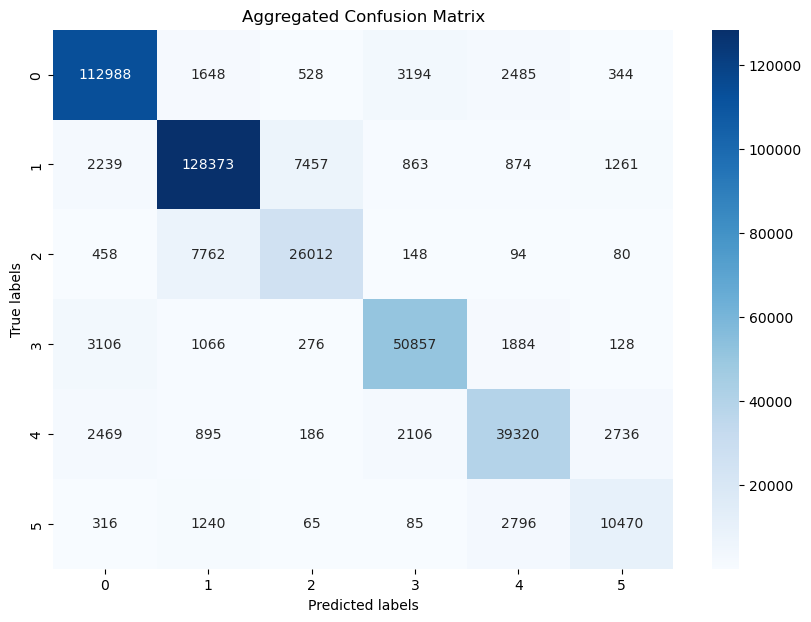

In [12]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix')
plt.show()

In [74]:
import joblib
# Assuming classifier is your trained Naive Bayes model
joblib.dump(classifier, 'naive_bayes_emotion_classifier.pkl')
classifier_loaded = joblib.load('naive_bayes_emotion_classifier.pkl')

In [75]:
from flask import Flask, request, jsonify
import joblib
import collections
from collections.abc import Sequence

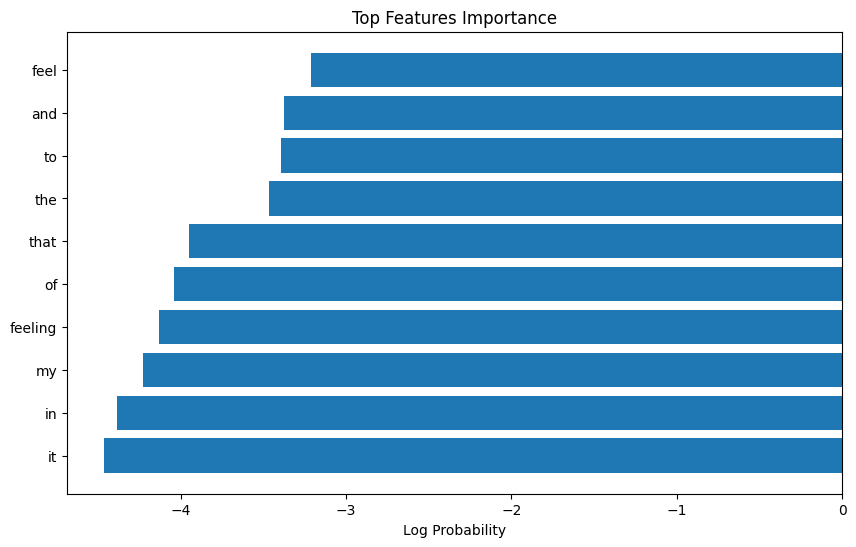

In [77]:
# For Naive Bayes, look at the probabilities
feature_importances = classifier.model_nb.feature_log_prob_
features = classifier.vectorizer.get_feature_names_out()

# sort them or just select the top few
sorted_idx = np.argsort(feature_importances[1])  # Index 1 for positive class, 0 for negative
top_features = np.array(features)[sorted_idx][-10:]

plt.figure(figsize=(10, 6))
plt.barh(top_features, feature_importances[1][sorted_idx][-10:])
plt.xlabel('Log Probability')
plt.title('Top Features Importance')
plt.show()



# Emotion Classifier using SVM with RBF Kernel (non-Linear SVM)

In [5]:
class NonLinearSVM:
    def __init__(self):
        self.model = SVC(kernel='rbf') 
        self.vectorizer = CountVectorizer()

    def train(self, X_train, y_train):
        X_train_vect = self.vectorizer.fit_transform(X_train)
        features = self.vectorizer.get_feature_names_out()
        print("Total number of features:", len(features))
        print("First 5 features:", features[:5])
        self.model.fit(X_train_vect, y_train)

    def predict(self, X):
        X_vect = self.vectorizer.transform(X)
        return self.model.predict(X_vect)
    
    def save_model(self, file_path):
        with open(file_path, 'wb') as f:
            pickle.dump((self.model, self.vectorizer), f)

    def load_model(self, file_path):
        with open(file_path, 'rb') as f:
            self.model, self.vectorizer = pickle.load(f)
    
    @staticmethod
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
        tokens = word_tokenize(text)
        negation_terms = {'not', 'no', 'never', 'none'}
        tokens = ['not_' + tokens[i+1] if tokens[i] in negation_terms and i+1 < len(tokens) else token 
                  for i, token in enumerate(tokens)]
        return ' '.join(tokens)


In [6]:
df = pd.read_csv('../text.csv')
df['processed_text'] = df['text'].apply(NonLinearSVM.preprocess_text)

df.head()

,Unnamed: 0,text,label,processed_text
0,0,i just feel really helpless and heavy hearted,4,i just feel really helpless and heavy hearted
1,1,ive enjoyed being able to slouch about relax a...,0,ive enjoyed being able to slouch about relax a...
2,2,i gave up my internship with the dmrg and am f...,4,i gave up my internship with the dmrg and am f...
3,3,i dont know i feel so lost,0,i dont know i feel so lost
4,4,i am a kindergarten teacher and i am thoroughl...,4,i am a kindergarten teacher and i am thoroughl...


In [7]:
def cross_validate_evaluate(X, y):
    kf = KFold(n_splits=2, random_state=42, shuffle=True)
    acc_scores, prec_scores, f1_scores = [], [], []
    aggregated_cm = np.zeros((6, 6))  

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        classifier = NonLinearSVM()
        classifier.train(X_train, y_train)
        y_pred = classifier.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        prec_scores.append(precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
        aggregated_cm += cm

        classifier.save_model('nonLinearSVM_last_fold.pkl')

    return acc_scores, prec_scores, f1_scores, aggregated_cm

In [8]:
X = df['processed_text'].to_numpy()
y = df['label'].to_numpy()

acc, prec, f1, cm = cross_validate_evaluate(X, y)

print(f"Average Accuracy: {np.mean(acc)}")
print(f"Average Precision: {np.mean(prec)}")
print(f"Average F1-Score: {np.mean(f1)}")


Total number of features: 57697
First 5 features: ['aa' 'aaa' 'aaaaaaaaaaaaaaaaggghhhh' 'aaaaaaaall' 'aaaaaand']
Total number of features: 57646
First 5 features: ['aa' 'aaa' 'aaaa'
 'aaaaaaaaaaaaaaarrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrggggggggggggggggggggggggggggghhhhhhhhhhhhhh'
 'aaaaaaand']


In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix')
plt.show()